In [1]:
# set gpu to use 3
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


2025-09-30 19:29:47.183911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/workspace/.venv/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
I0000 00:00:1759260594.495716  224991 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21895 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


(160000,)


2025-09-30 19:29:57.346102: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b038406daa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-30 19:29:57.346139: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-30 19:29:57.761021: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-30 19:29:57.799834: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-09-30 19:29:58.829575: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_55', 72 bytes spill stores, 72 bytes spill loads

2025-09-30 19:29:59.173884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas wa

(1, 1536)
(1, 16, 4, 1536)
(1, 14795)


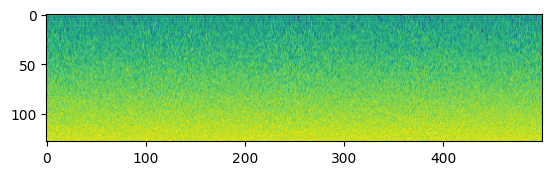

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Load the model.
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/perch_v2/2')

# Input: 5 seconds of silence as mono 32 kHz waveform samples.
waveform = np.random.uniform(-1, 1, 5 * 32000).astype(np.float32)
print(waveform.shape)

# Run the model, check the output.
model_outputs = model.signatures['serving_default'](inputs=waveform[np.newaxis, :])

# Examine the spectrogram.
plt.imshow(model_outputs['spectrogram'][0].T)

# Examine the embeddings.
print(model_outputs['embedding'].shape)
print(model_outputs['spatial_embedding'].shape)

# Examine the logits.
print(model_outputs['label'].shape)

In [3]:
# get min, max, mean, std of logits
print(tf.reduce_min(model_outputs['label']))
print(tf.reduce_max(model_outputs['label']))
print(tf.reduce_mean(model_outputs['label']))
print(tf.math.reduce_std(model_outputs['label']))

tf.Tensor(-9.122648, shape=(), dtype=float32)
tf.Tensor(6.577464, shape=(), dtype=float32)
tf.Tensor(-1.501216, shape=(), dtype=float32)
tf.Tensor(1.9922757, shape=(), dtype=float32)


In [4]:
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.datamodule.base_datamodule import DatasetConfig, BirdSetTransformsWrapper

dataset_name = "HSN"  # "NA-BIRD-PASSIVE"


dm = BirdSetDataModule(
    dataset= DatasetConfig(
        data_dir="/workspace/data_birdset",
        hf_path='DBD-research-group/BirdSet',
        hf_name=dataset_name,
        n_workers=3,
        val_split=0.0001,
        task="multilabel",
        classlimit=500, 
        eventlimit=5, 
        sample_rate=32_000,
    ),
    transforms=BirdSetTransformsWrapper(
        sample_rate=32_000,
        model_type="waveform",
    ),
)
dm.prepare_data()
dm.setup("test")


/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Train event mapping (num_proc=3):   0%|          | 0/5460 [00:00<?, ? examples/s]

sampling: unique-identifier:   0%|          | 0/38170 [00:00<?, ? examples/s]

sampling: 100%|██████████| 21/21 [00:01<00:00, 11.76it/s]


One-hot-encoding train labels.:   0%|          | 0/17940 [00:00<?, ? examples/s]

/workspace/birdset/datamodule/base_datamodule.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)


One-hot-encoding test_5s labels.:   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17938 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

In [5]:
# get sample from the test set
dm.test_dataset[0]['input_values'].shape

/workspace/birdset/datamodule/components/transforms.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float16)


torch.Size([1, 160000])

In [6]:
sample1 = dm.test_dataset[0]['input_values']
sample1 = sample1.detach().squeeze(0).cpu().numpy()
sample1.shape
logits = model.signatures['serving_default'](inputs=sample1[np.newaxis, :])['label']
print(logits.shape)

(1, 14795)


In [7]:
len(dm.test_dataset)

12000

In [8]:
# iterate over the test set
import tqdm


logits = []
targets = []    

for i in range(len(dm.test_dataset)):
    sample = dm.test_dataset[i]
    input_numpy = sample['input_values'].squeeze(0).cpu().numpy()
    output = model.signatures['serving_default'](inputs=input_numpy[np.newaxis, :])
    logits.append(output['label'].numpy())
    targets.append(sample['labels'].numpy())

In [9]:
import torch


logits = torch.tensor(np.vstack(logits))
targets = torch.tensor(np.vstack(targets))

In [10]:
logits.shape, targets.shape

(torch.Size([12000, 14795]), torch.Size([12000, 21]))

In [11]:
import datasets
import pandas as pd


pretrain_classlabels = pd.read_csv(
    "/workspace/projects/uncertainbird/resources/perch_v2_ebird_classes.csv"
)
# Extract the 'ebird2021' column as a list
pretrain_classlabels = pretrain_classlabels["ebird2021"].tolist()

# Load dataset information
dataset_info = datasets.load_dataset_builder(
    'DBD-research-group/BirdSet', 'XCL'
).info
dataset_classlabels = dataset_info.features["ebird_code"].names
print(f"Pretrained model classes: {len(pretrain_classlabels)}")
print(f"XCL classes: {len(dataset_classlabels)}")

# Create the class mask
class_mask = [
    pretrain_classlabels.index(label)
    for label in dataset_classlabels
    if label in pretrain_classlabels
]
class_indices = [
    i
    for i, label in enumerate(dataset_classlabels)
    if label in pretrain_classlabels
]

# Log missing labels
missing_labels = [
    label
    for label in dataset_classlabels
    if label not in pretrain_classlabels
]
if missing_labels:
    print(f"Missing labels in pretrained model: {missing_labels}")
print(f"Missing labels size: {len(missing_labels)}")

Pretrained model classes: 14795
XCL classes: 9736
Missing labels in pretrained model: ['grskiw1', 'dusscr1', 'butpig1', 'cregui3', 'crebob2', 'chhpar3', 'rinphe1', 'rinphe2', 'shefra1', 'chnfra2', 'chnfra3', 'bawnig3', 'sptnig1', 'granig3', 'bronig1', 'bksnig1', 'monnig1', 'rufpot1', 'gerswi1', 'alpswi1', 'motswi2', 'antman2', 'amtsun3', 'amtsun2', 'amtsun4', 'boorat1', 'boorat2', 'rubrat1', 'brarub1', 'whtmog2', 'lotsab1', 'stream2', 'stream3', 'vichum', 'grfhum1', 'manhum1', 'bfgbir1', 'grygab1', 'wbgbir1', 'puctur2', 'ruwtur2', 'prrtur1', 'whctur1', 'viotur1', 'rostur1', 'karbus1', 'ruebus1', 'savbus1', 'bucbus1', 'recbus1', 'blabus3', 'whqbus1', 'whbcou3', 'lobcuc1', 'hobcuc1', 'blecuc1', 'rtbcuc1', 'shbcuc1', 'webcuc1', 'libcuc1', 'palcuc1', 'whckoe1', 'brucuc2', 'lemdov2', 'matdov1', 'eurcod2', 'spodov', 'laudov1', 'mantho1', 'wbgdov1', 'wtgdov1', 'frgdov1', 'scgdov1', 'whigrp1', 'yebfrd1', 'yebfrd2', 'spiimp2', 'mouimp1', 'wsfrai1', 'chfrai1', 'forrai1', 'virrai1', 'afrcra1', 'o

In [12]:
# use class mask on logits
full_logits = torch.full(
    (logits.shape[0], 9736),  # Assuming 9736 is the total number of classes
    0.0,
    device=logits.device,
    dtype=logits.dtype,
)
# Extract valid logits using indices from class_mask and directly place them
full_logits[:, class_indices] = logits[:, class_mask]
logits = full_logits
logits.shape

torch.Size([12000, 9736])

In [13]:
# expand targets to 9736 classes
target_pretrain_classlabels = datasets.load_dataset_builder(
    'DBD-research-group/BirdSet', 'XCL'
).info.features["ebird_code"]
target_dataset_classlabels = datasets.load_dataset_builder(
    'DBD-research-group/BirdSet', dataset_name
).info.features["ebird_code"]
target_mask = [
    target_pretrain_classlabels.names.index(i) for i in target_dataset_classlabels.names
]
full_targets = torch.zeros(
    (targets.shape[0], 9736),  # Assuming 9736 is the total number of classes
    device=targets.device,
    dtype=targets.dtype,
)
full_targets[:, target_mask] = targets
targets = full_targets
targets.shape

torch.Size([12000, 9736])

In [14]:
from uncertainbird.utils.plotting import print_metrics

predictions = torch.softmax(logits, dim=1)
# cast targets to int
targets = targets.to(torch.int)

metrics = print_metrics(
    predictions,
    targets)


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.buc

Accuracy: tensor(0.9999)
cmAP: tensor(0.5050)
Precision: tensor(0.0011)
Recall: tensor(0.0002)
F1 Score: tensor(0.0003)
AUROC: tensor(0.0019)
ECE: tensor(0.0001)
ECE Weighted: tensor(0.1082)
ECE Top-3: tensor(0.1089)
ECE Top-5: tensor(0.0809)
ECE Top-10: tensor(0.0437)
ECE Top-21: tensor(0.0214)
Miscalibration Score (MCS): tensor(-0.1081)
ECE Under-confidence: tensor(0.1082)
ECE Over-confidence: tensor(4.4097e-05)


<Axes: title={'center': 'Reliability Diagram'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

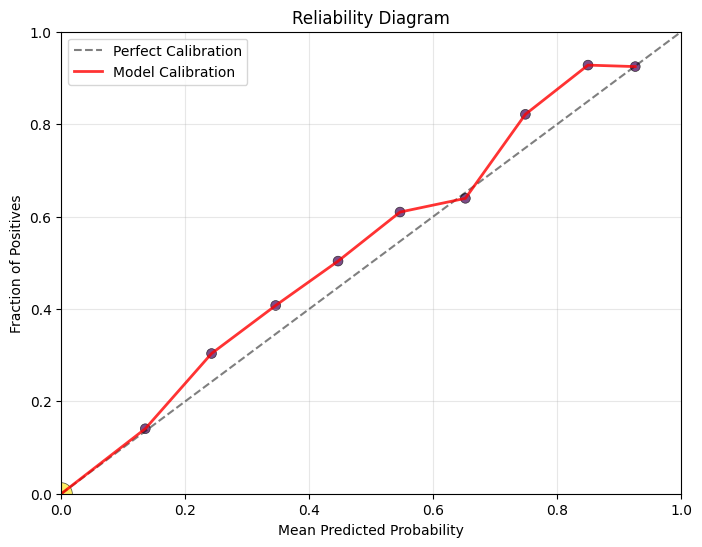

In [15]:
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions,
    targets,
    n_bins=10)